This notebook is about using machine learning to create a model that predicts which passengers survived the Titanic shipwreck. The dataset comes from "Titanic: Machine Learning from Disaster" - one of competitions from kaggle.com. We are going to use various machine learning methods and compare them using accuracy and Gini Index. 

We start with loading useful libraries. We will use data.table for many data related operations. We will also have to use sqldf library to perform few more specific selections from the data that data.table struggles with. 

In [1]:
library(data.table)
library(sqldf)
library(ggplot2)
set.seed(101)

Loading required package: gsubfn

Loading required package: proto

Warning message:
“no DISPLAY variable so Tk is not available”
Loading required package: RSQLite



The next step is loading the dataset. 

In [2]:
dane=read.csv('../input/titanic/train.csv')
dane=data.table(dane)

Now we should look at the dataset.

In [3]:
summary(dane)

  PassengerId       Survived          Pclass     
 Min.   :  1.0   Min.   :0.0000   Min.   :1.000  
 1st Qu.:223.5   1st Qu.:0.0000   1st Qu.:2.000  
 Median :446.0   Median :0.0000   Median :3.000  
 Mean   :446.0   Mean   :0.3838   Mean   :2.309  
 3rd Qu.:668.5   3rd Qu.:1.0000   3rd Qu.:3.000  
 Max.   :891.0   Max.   :1.0000   Max.   :3.000  
                                                 
                                    Name         Sex           Age       
 Abbing, Mr. Anthony                  :  1   female:314   Min.   : 0.42  
 Abbott, Mr. Rossmore Edward          :  1   male  :577   1st Qu.:20.12  
 Abbott, Mrs. Stanton (Rosa Hunt)     :  1                Median :28.00  
 Abelson, Mr. Samuel                  :  1                Mean   :29.70  
 Abelson, Mrs. Samuel (Hannah Wizosky):  1                3rd Qu.:38.00  
 Adahl, Mr. Mauritz Nils Martin       :  1                Max.   :80.00  
 (Other)                              :885                NA's   :177    
     Sib

We can notice that we have a lot of missing data. We are going to impute some of the missing values, starting with variable Age. We will take advantage of titles included in Name variable and fill NAs in Age using means.

In [4]:
Miss=sqldf('SELECT Age FROM dane WHERE Name like "%Miss.%" and Age IS NOT NULL')
srMiss=mean(Miss[,1])
dane[Name %like% "Miss." &is.na(Age)==1]$Age=srMiss

Master=sqldf('SELECT Age FROM dane WHERE Name like "%Master.%" and Age IS NOT NULL')
srMaster=mean(Master[,1])
dane[Name %like% "Master" & is.na(Age)==1]$Age=srMaster

Mrs=sqldf('SELECT Age FROM dane WHERE Name like "%Mrs.%" and Age IS NOT NULL')
srMrs=mean(Mrs[,1])
dane[Name %like% "Mrs."& is.na(Age)==1]$Age=srMrs

Mr=sqldf('SELECT Age FROM dane WHERE Name like "%Mr.%" and Age IS NOT NULL')
srMr=mean(Mr[,1])
dane[Name %like% "Mr."& Sex=='male'& is.na(Age)==1]$Age=srMr

Dr=sqldf('SELECT Age FROM dane WHERE Name like "%Dr.%" and Age IS NOT NULL')
srDr=mean(Dr[,1])
dane[is.na(Age)==1 & Name %like% "Dr."]$Age=srDr

Variable Embarked has 2 missing values. We will simply rewrite them as the most common of all values - letter "S".

In [5]:
unique(dane$Embarked)[4]
dane[Embarked==unique(dane$Embarked)[4],]$Embarked='S'
dane[,Embarked:=factor(Embarked)]

[1] 
Levels:  C Q S

We are not going to use Cabin variable as it is so we skip it for now.

Now we are going to add a few new columns. We start with column called 'zb' that will be used to split the dataset into two parts - training set and testing set. 

In [6]:
dane=dane[,zb:=sample(c(0,1),size=891,prob=c(0.7,0.3),replace=TRUE)]

The first new feature we are going to add is the title of a passenger. This variable will be very similar to Sex variable so we will have to abandon at least one of them.

In [7]:
dane[,Title:=gsub(".*, ","",Name)]
dane[,Title:=gsub("\\..*","", Title)]
dane[,Title:=factor(Title)]

We should be aware that there are tickets that have the same code and Fare for more than one person. We will create new variable FareN, that will describe fore per person.

In [8]:
Ticket7=sqldf('SELECT COUNT(*) as NumofTickets, Ticket FROM dane group by Ticket having(NumofTickets)=7 ')
Ticket7=unique(Ticket7$Ticket)

Ticket6=sqldf('SELECT COUNT(*) as NumofTickets, Ticket FROM dane group by Ticket having(NumofTickets)=6 ')
Ticket6=unique(Ticket6$Ticket)

Ticket5=sqldf('SELECT COUNT(*) as NumofTickets, Ticket FROM dane group by Ticket having(NumofTickets)=5 ')
Ticket5=unique(Ticket5$Ticket)

Ticket4=sqldf('SELECT COUNT(*) as NumofTickets, Ticket FROM dane group by Ticket having(NumofTickets)=4 ')
Ticket4=unique(Ticket4$Ticket)

Ticket3=sqldf('SELECT COUNT(*) as NumofTickets, Ticket FROM dane group by Ticket having(NumofTickets)=3 ')
Ticket3=unique(Ticket3$Ticket)

Ticket2=sqldf('SELECT COUNT(*) as NumofTickets, Ticket FROM dane group by Ticket having(NumofTickets)=2 ')
Ticket2=unique(Ticket2$Ticket)

In [9]:
dane[,FareN:=Fare]
for (i in 2:7)
{ 
    dane[Ticket %in% eval(parse(text=paste0(text='Ticket',i,collapse=''))),FareN:=Fare/i]
}

We will also look at the information included in Cabin variable. We will split those values into categories. Missing values will be merged with those that are very rare.

In [10]:
dane[,CabN:=ifelse(Cabin %like% "A","cabA",ifelse(Cabin %like% "B","cabB",ifelse(Cabin %like% "C","cabC", ifelse(Cabin %like% "D","cabD",ifelse(Cabin %like% "E" ,"cabE",ifelse(Cabin %like% "F" | Cabin %like% "G" | Cabin %like% "T","cabF","cabU" ) ) )) ) )]
dane[,CabN:=factor(CabN)]

The last new feature is number of family members that on the ship.

In [11]:
dane[,Family:=Parch+SibSp]

Now we split the data.

In [12]:
trn=dane[zb==0]
val=dane[zb==1]

# WOE approach

In this section we will encode all categorical data with Weight of Evidence and using Information Value we will decide which variables are the best for predicting the survival of passengers. We will also bin the FareN values with 10 WOE bins.

In [13]:
library(Information)

dane[,Pclass:=factor(Pclass)]

WOE_table <- create_infotables(data=trn[,c('Pclass','Sex','Age','SibSp','Parch', 'Embarked','Title','FareN','CabN','Family','Survived')], y="Survived", parallel=FALSE)
WOE_table

$Tables
$Tables$Pclass
  Pclass   N   Percent        WOE        IV
1  [1,1] 147 0.2333333  1.1016243 0.2935902
2  [2,2] 136 0.2158730  0.3516665 0.3211894
3  [3,3] 347 0.5507937 -0.7062309 0.5648306

$Tables$Sex
     Sex   N   Percent        WOE        IV
1 female 221 0.3507937  1.4632911 0.7560191
2   male 409 0.6492063 -0.9464184 1.2449925

$Tables$Age
            Age  N    Percent        WOE         IV
1     [0.42,15] 59 0.09365079  0.7374022 0.05333551
2     [16,20.5] 64 0.10158730 -0.2176865 0.05800676
3       [21,22] 63 0.10000000  0.2113091 0.06257286
4       [23,26] 64 0.10158730 -0.2176865 0.06724410
5       [27,29] 53 0.08412698  0.0777777 0.06775764
6       [30,32] 47 0.07460317  0.2854171 0.07401078
7  [32.37,32.5] 88 0.13968254 -1.5551326 0.31810872
8       [33,37] 65 0.10317460  0.7152143 0.37338113
9       [38,47] 63 0.10000000 -0.3407595 0.38442615
10      [48,80] 64 0.10158730  0.3109389 0.39455127

$Tables$SibSp
  SibSp   N   Percent        WOE         IV
1 [0,0] 428 

In [14]:
WOE_table$Summary

,Variable,IV
,<chr>,<dbl>
7,Title,1.36837793
2,Sex,1.24499247
1,Pclass,0.56483060
8,FareN,0.54853431
9,CabN,0.53268706
3,Age,0.39455127
10,Family,0.24156003
6,Embarked,0.16689288
5,Parch,0.11917747


We are going to pick variables that present the good predictive power. It seems that we should get Age, Pclass, FareN, CabN. We will also pick weaker Family variable and Sex that might cause overfitting.
Now we simply change values of categorical variables (and FareN) to WOE.

In [15]:
trnWOE=trn
trnWOE[Pclass==1,PclassW:=1.1016243]
trnWOE[Pclass==2,PclassW:=0.3516665]
trnWOE[Pclass==3,PclassW:=-0.7062309]
trnWOE[Sex=='male',SexW:=-0.9464184]
trnWOE[Sex=='female',SexW:=1.4632911]

trnWOE[Age<15,AgeW:=-0.84474358]
trnWOE[Age >= 15 & Age<21 ,AgeW:=0.7374022]
trnWOE[Age >= 21 & Age<23 ,AgeW:=0.2113091]
trnWOE[Age >= 23 & Age<27 ,AgeW:=-0.2176865]
trnWOE[Age >= 27 & Age<30 ,AgeW:=0.0777777]
trnWOE[Age >= 30 & Age<32.3,AgeW:=0.2854171]
trnWOE[Age >=32.3 & Age<33,AgeW:=-1.5551326]
trnWOE[Age >=33 & Age<38,AgeW:=0.7152143]
trnWOE[Age >=38 & Age<48,AgeW:=-0.3407595]
trnWOE[Age >=48,AgeW:=0.3109389]

trnWOE[FareN<7.05,FareNW:=-0.84474358]
trnWOE[FareN >= 7.05 & FareN<7.65 ,FareNW:=-0.96734590]
trnWOE[FareN >= 7.65 & FareN<7.85 ,FareNW:=-0.96734590]
trnWOE[FareN >= 7.85 & FareN<8.05 ,FareNW:=-0.34075949]
trnWOE[FareN >= 8.05 & FareN<9.00 ,FareNW:=-0.42899561]
trnWOE[FareN >= 9.00 & FareN<11.71,FareNW:=-0.86928469]
trnWOE[FareN >=11.72 & FareN<14.50,FareNW:=-0.02907626]
trnWOE[FareN >=14.50 & FareN<26.55,FareNW:=0.05430534]
trnWOE[FareN >=26.55 & FareN<39.42,FareNW:=1.19213835]
trnWOE[FareN >=39.42,FareNW:=1.14561833]

trnWOE[CabN=='cabA',CabNW:=0.4989912]
trnWOE[CabN=='cabB',CabNW:=1.4372608]
trnWOE[CabN=='cabC',CabNW:=1.0379877]
trnWOE[CabN=='cabD',CabNW:=2.1729676]
trnWOE[CabN=='cabE',CabNW:=1.9459101]
trnWOE[CabN=='cabF',CabNW:=0.3448405]
trnWOE[CabN=='cabU',CabNW:=-0.3724741]


trnWOE[Family==0,FamilyW:=-0.38777713]
trnWOE[Family==1,FamilyW:=0.63479271]
trnWOE[Family==2,FamilyW:=0.81136585]
trnWOE[Family>2,FamilyW:=-0.01183446]


We do the same with val set.

In [16]:
valWOE=val
valWOE[Pclass==1,PclassW:=1.1016243]
valWOE[Pclass==2,PclassW:=0.3516665]
valWOE[Pclass==3,PclassW:=-0.7062309]
valWOE[Sex=='male',SexW:=-0.9464184]
valWOE[Sex=='female',SexW:=1.4632911]

valWOE[FareN<7.05,FareNW:=-0.84474358]
valWOE[FareN >= 7.05 & FareN<7.65 ,FareNW:=-0.96734590]
valWOE[FareN >= 7.65 & FareN<7.85 ,FareNW:=-0.96734590]
valWOE[FareN >= 7.85 & FareN<8.05 ,FareNW:=-0.34075949]
valWOE[FareN >= 8.05 & FareN<9.00 ,FareNW:=-0.42899561]
valWOE[FareN >= 9.00 & FareN<11.71,FareNW:=-0.86928469]
valWOE[FareN >=11.72 & FareN<14.50,FareNW:=-0.02907626]
valWOE[FareN >=14.50 & FareN<26.55,FareNW:=0.05430534]
valWOE[FareN >=26.55 & FareN<39.42,FareNW:=1.19213835]
valWOE[FareN >=39.42,FareNW:=1.14561833]

valWOE[CabN=='cabA',CabNW:=0.4989912]
valWOE[CabN=='cabB',CabNW:=1.4372608]
valWOE[CabN=='cabC',CabNW:=1.0379877]
valWOE[CabN=='cabD',CabNW:=2.1729676]
valWOE[CabN=='cabE',CabNW:=1.9459101]
valWOE[CabN=='cabF',CabNW:=0.3448405]
valWOE[CabN=='cabU',CabNW:=-0.3724741]


valWOE[Family==0,FamilyW:=-0.38777713]
valWOE[Family==1,FamilyW:=0.63479271]
valWOE[Family==2,FamilyW:=0.81136585]
valWOE[Family>2,FamilyW:=-0.01183446]

valWOE[Age<15,AgeW:=-0.84474358]
valWOE[Age >= 15 & Age<21 ,AgeW:=0.7374022]
valWOE[Age >= 21 & Age<23 ,AgeW:=0.2113091]
valWOE[Age >= 23 & Age<27 ,AgeW:=-0.2176865]
valWOE[Age >= 27 & Age<30 ,AgeW:=0.0777777]
valWOE[Age >= 30 & Age<32.3,AgeW:=0.2854171]
valWOE[Age >=32.3 & Age<33,AgeW:=-1.5551326]
valWOE[Age >=33 & Age<38,AgeW:=0.7152143]
valWOE[Age >=38 & Age<48,AgeW:=-0.3407595]
valWOE[Age >=48,AgeW:=0.3109389]

Now our dataset is ready to use. The first method that we are going to consider is decision tree with pruning. We are going to load another necessary libraries.

In [17]:
library(rpart)
library(ROCR)

Now we are going to define function that computes Gini Index and plots ROC curve.

In [18]:
rocplot=function(pred,truth,...)
    {
    predob=prediction(pred,truth)
    perf=performance(predob,'tpr','fpr')
    gini=2*attributes(performance(predob,"auc"))$y.values[[1]]-1
    plot(perf,main=paste0("Gini index: ",round(gini,2)))
    invisible()
}

Using variables:

In [19]:
NamesofColumns=c('SexW','PclassW', 'FareNW', 'CabNW','FamilyW','Age')
Predictors=as.vector(NamesofColumns)
form=as.formula(paste("Survived","~",paste(Predictors,collapse='+')))

Now, the most crucial piece of code. We create large tree with intention to cut some branches off.


Classification tree:
rpart(formula = form, data = trnWOE, method = "class", minsplit = 10, 
    minbucket = 5, cp = 1e-11)

Variables actually used in tree construction:
[1] Age     CabNW   FamilyW FareNW  PclassW SexW   

Root node error: 238/630 = 0.37778

n= 630 

          CP nsplit rel error  xerror     xstd
1 4.1597e-01      0   1.00000 1.00000 0.051131
2 3.9916e-02      1   0.58403 0.58403 0.043732
3 1.6807e-02      3   0.50420 0.52941 0.042185
4 1.3655e-02      4   0.48739 0.55882 0.043038
5 1.0504e-02     11   0.38655 0.52101 0.041931
6 4.2017e-03     13   0.36555 0.44118 0.039303
7 2.8011e-03     16   0.35294 0.44958 0.039600
8 1.5756e-03     19   0.34454 0.45798 0.039892
9 1.0000e-11     27   0.33193 0.47059 0.040321


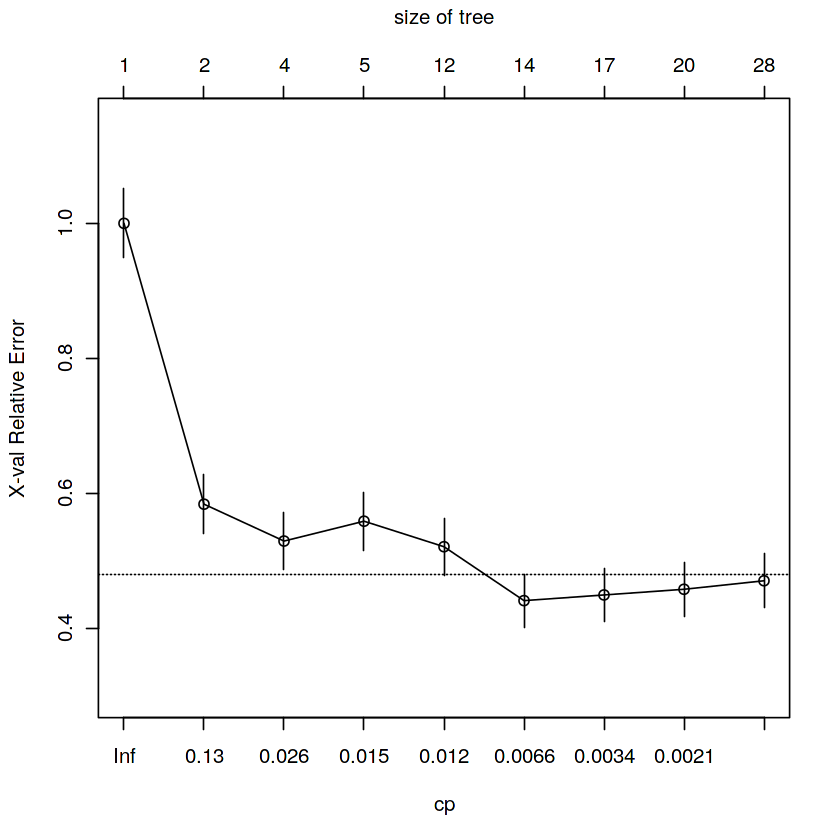

     prediction
truth   0   1
    0 146  11
    1  35  69

[1] 0.8237548

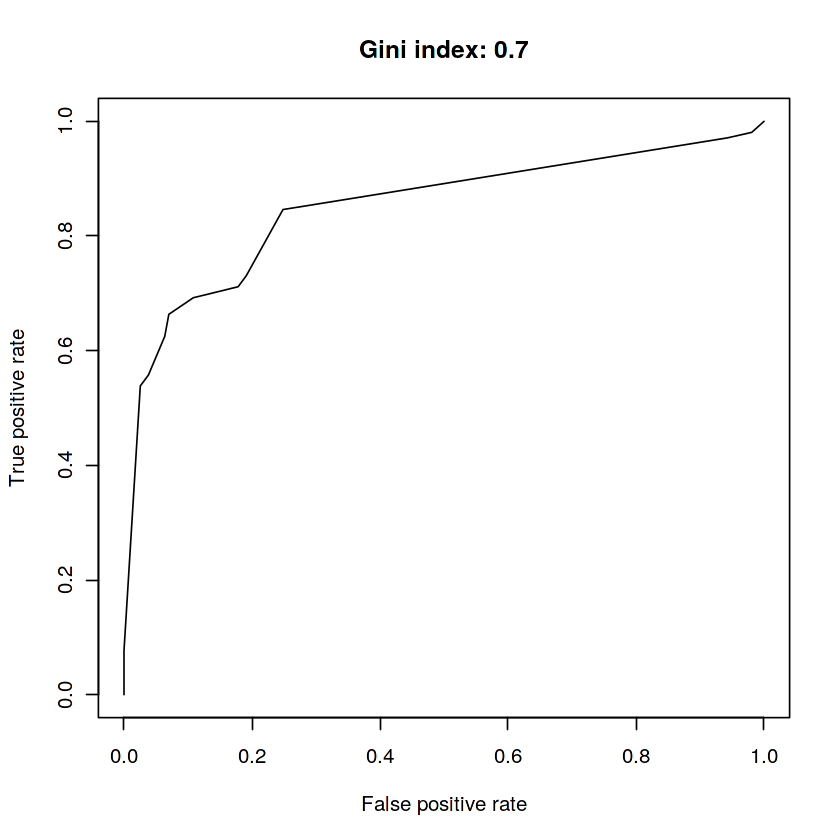

In [20]:
set.seed(1234)
rTree=rpart(form,data=trnWOE,minsplit=10,minbucket=5,method="class",cp=0.00000000001)
cp=data.table(printcp(rTree))
plotcp(rTree)
rTreePruned=prune(rTree,cp=cp[which.min(cp$xerror),]$CP)
g_rTreePruned=rocplot(predict(rTreePruned,valWOE,type="prob")[,2],valWOE$Survived)
(confMat=table(truth=valWOE$Survived,prediction=predict(rTreePruned,valWOE,type='class')))
sum(diag(confMat))/sum(confMat)

We received a lot of useful information. We see that accuracy on the validation set is equal to 0.823754789272031. We see that Gini Index equals 0.7. From confusion matrix we can see that our tree classified 30 people who survived as dead.

Next we will fit Random Forest. We have to find the optimal number of predictors. After trying every possible answer (there are only 6 predictors) we obtained that the best number of predictors is 5. 

To fit the model we need library randomForest and we have to make sure that the goal variable is treated as factor.

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




   
      0   1
  0 142  15
  1  32  72


[1] 0.8199234

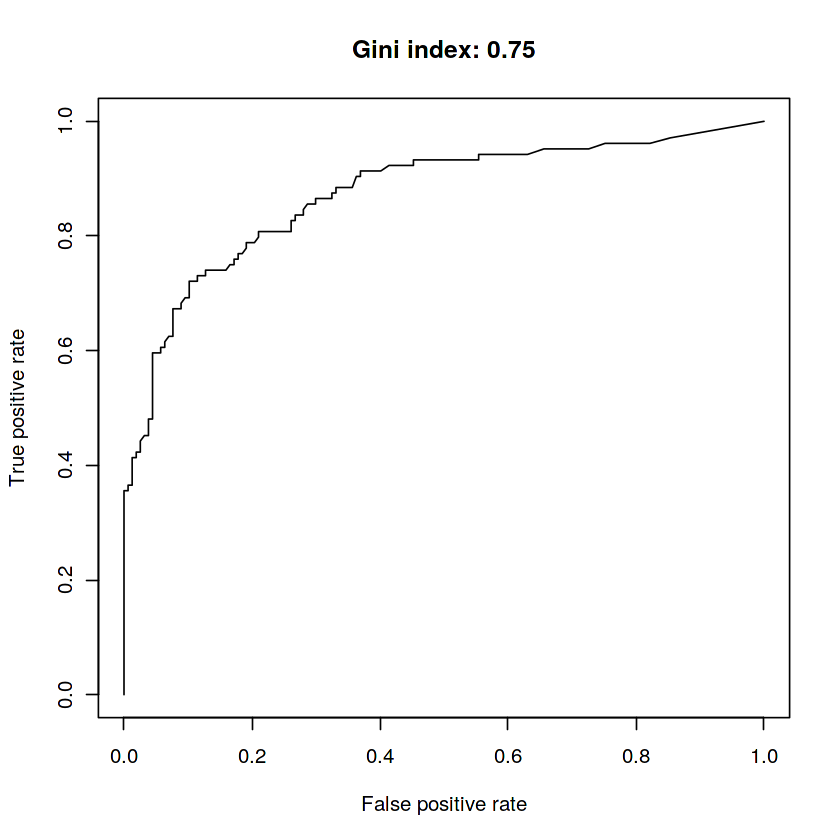

In [21]:
library(randomForest)
set.seed(1234)
trnWOE$Survived=factor(trnWOE$Survived)
valWOE$Survived=factor(valWOE$Survived)
randForest=randomForest(form,data=trnWOE,mtry=5,ntree=1000,nodesize=10,importance=TRUE,keep.inbag=TRUE,keep.forest=TRUE)
g_bagForest=rocplot(predict(randForest,valWOE,type='prob')[,2],valWOE$Survived)
confMat=table(valWOE$Survived,predict(randForest,valWOE,type='class'))
print(confMat)
sum(diag(confMat))/sum(confMat)

We can use the same function to perform bagging. We simply take mtry equals to maximum number of predictors.

   
      0   1
  0 141  16
  1  30  74


[1] 0.8237548

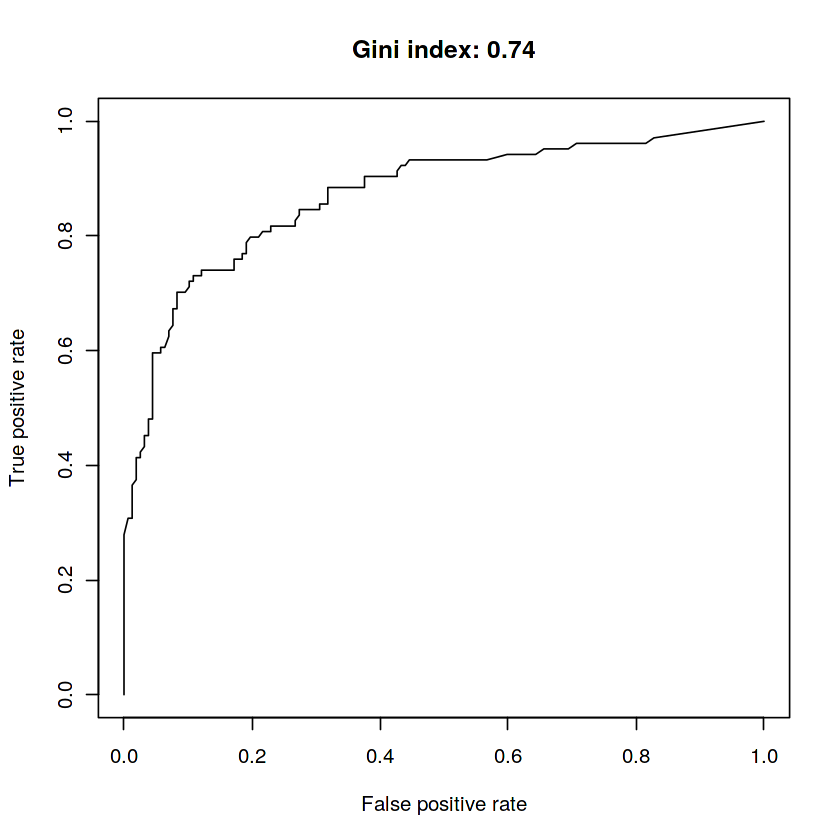

In [22]:
set.seed(1234)
bagForest=randomForest(form,data=trnWOE,mtry=6,ntree=1000,nodesize=10,importance=TRUE,keep.inbag=TRUE,keep.forest=TRUE)
g_bagForest=rocplot(predict(bagForest,valWOE,type='prob')[,2],valWOE$Survived)
confMat=table(valWOE$Survived,predict(bagForest,valWOE,type='class'))
print(confMat)
sum(diag(confMat))/sum(confMat)

The next method is GBM boosting. We have to ensure that goal variables are integers.

In [23]:
library(gbm)
trnWOE[,Survived:=as.integer(Survived)-1]
valWOE[,Survived:=as.integer(Survived)-1]

Loaded gbm 2.1.8



GBM boosting require two parameters, interaction depth and shrinkage. After trying a few different options we obtained that the best one was (6,0.01).

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.



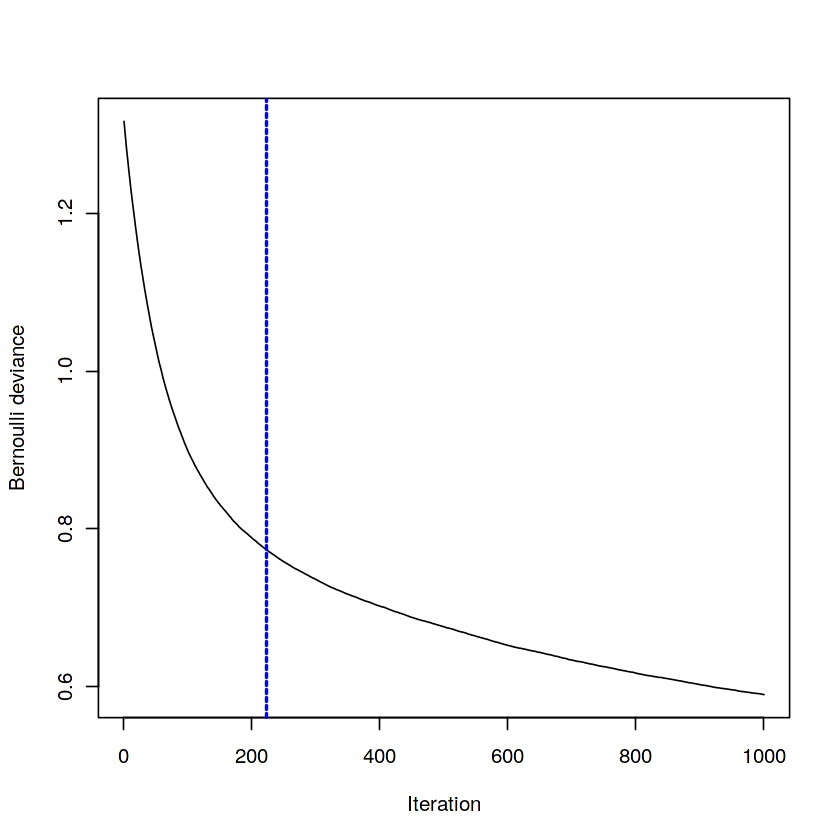

[1] 0.816092

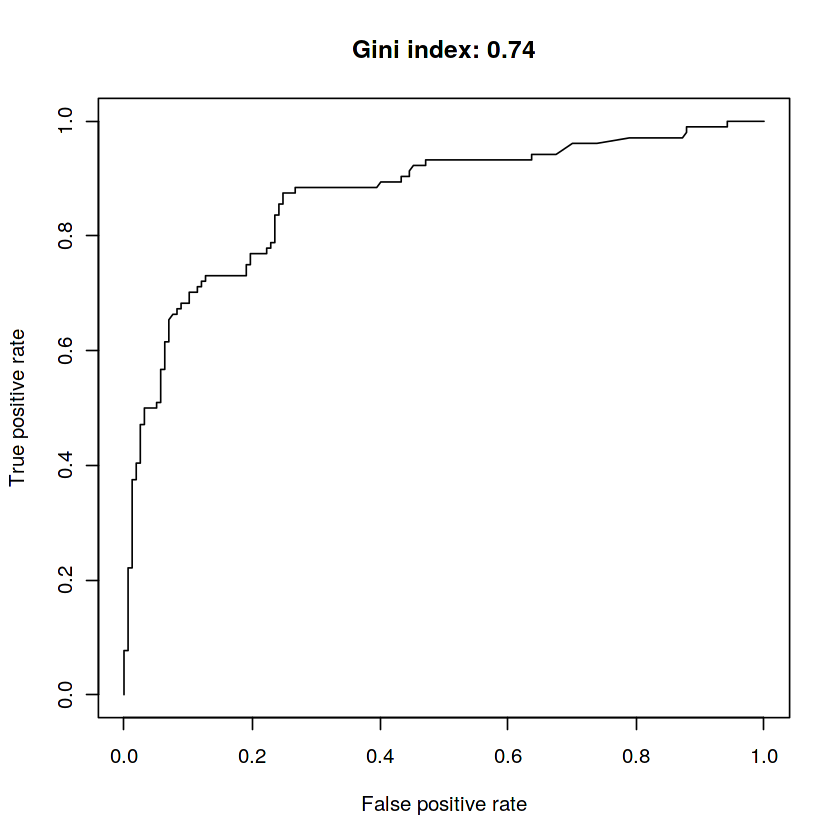

In [24]:
set.seed(1234)
boostForest=gbm(form,data=trnWOE,distribution='bernoulli',n.trees=1000,interaction.depth=6,shrinkage=0.01,n.minobsinnode=10)
iterOpt=gbm.perf(boostForest)
testPredict=predict.gbm(boostForest,newdata=valWOE,n.trees=iterOpt,type='response')
g_boostForest=rocplot(testPredict,valWOE$Survived)
confMat=table(valWOE$Survived,ifelse(testPredict>0.5,1,0))
sum(diag(confMat))/sum(confMat)

Another boosting method available is discrete ADAboost. We need library "ada" to use it.

   
      0   1
  0 141  16
  1  27  77


[1] 0.835249

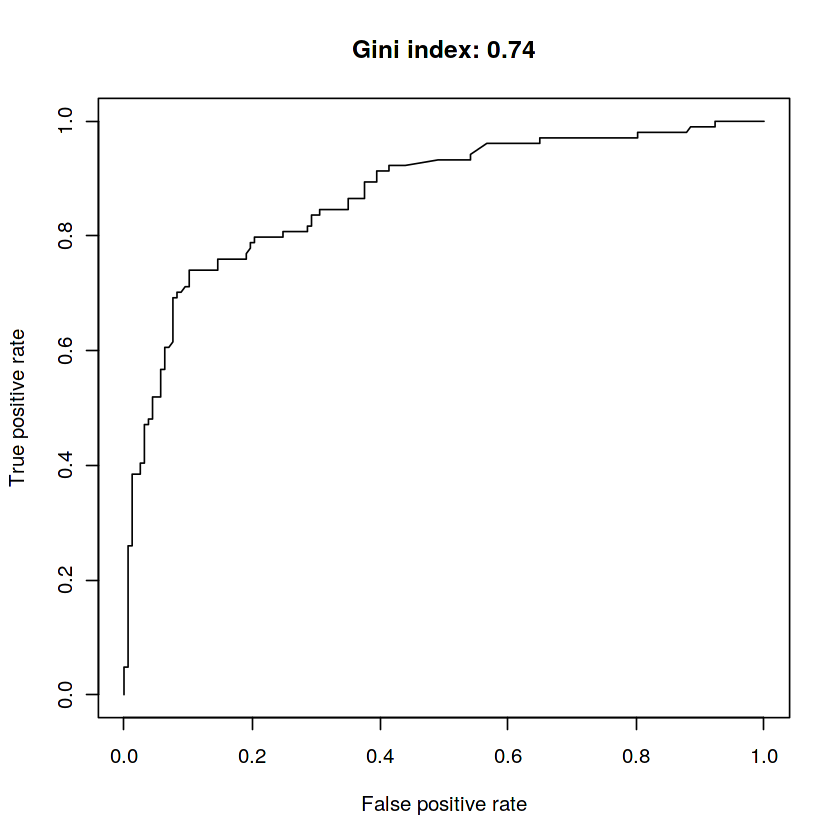

In [25]:
library(ada)
set.seed(1234)
default=rpart.control()
adaDisc=ada(form,data=trnWOE,iter=500,test.x=valWOE[,.SD,.SDcols=setdiff(names(valWOE),'Survived')],test.y=valWOE$Survived,loss='e',type='discrete',control=default)
g_adaDisc=rocplot(predict(adaDisc,valWOE,type='prob',n.iter=which.min(adaDisc$model$errs[,3]))[,2],val$Survived)
confMat=table(valWOE$Survived,predict(adaDisc,valWOE,n.iter=which.min(adaDisc$model$errs[,3])))
print(confMat)
sum(diag(confMat))/sum(confMat)

The last method that we are going to consider here is SVM with linear kernel. It requires another library and encoding goal variables to {-1,1}.

In [26]:
library(e1071)
trnWOE1=copy(trnWOE)
valWOE1=copy(valWOE)
trnWOE1[Survived==0,Survived:=-1]
valWOE1[Survived==0,Survived:=-1]

We start with some arbitrary parameters. They will change after tuning.

In [27]:
set.seed(1234)
modelSVM=svm(form,data=trnWOE1,kernel='linear',cost=10,scale=FALSE)
svmTune=tune(svm,train.x=trnWOE1[,c(6,18,19,21,22,23)],train.y=trnWOE1[,2],kernel='linear',ranges=list(cost=10^(-2:2)))

We get the best parameters from printing:

In [28]:
print(svmTune)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
 0.01

- best performance: 0.7639212 



In [29]:
svmTuned=svm(form,data=trnWOE1,kernel='linear',cost=0.01,scale=FALSE)

     predict
truth  -1   1
   -1 137  20
   1   31  73

[1] 0.8045977

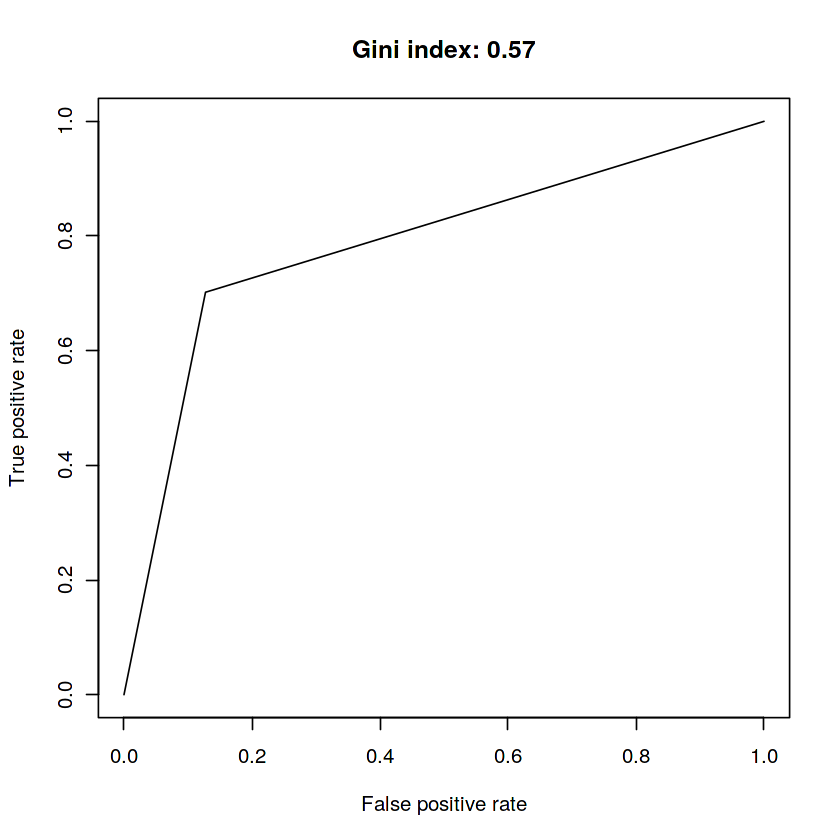

In [30]:
svmPred=predict(svmTuned,valWOE1[,c(6,18,19,20,21,22)],type='prob')
(confMat=table(truth=valWOE1$Survived,predict=ifelse(svmPred>0,1,-1)))
rocplot(ifelse(svmPred>0,1,-1),val$Survived)
sum(diag(confMat))/sum(confMat)

Let's get all results in one table.

In [31]:
results_WOE=data.table(Method=c('PrunedTree','RandomForest','BagForest','BoostForest','ADAdisc','SVMlinear'),Accuracy=c(0.824,0.820,0.824,0.816,0.835,0.805), GiniIndex=c(0.70,0.75,0.74,0.74,0.74,0.57))
results_WOE[order(Accuracy,decreasing=TRUE)]

Method,Accuracy,GiniIndex
<chr>,<dbl>,<dbl>
ADAdisc,0.835,0.74
PrunedTree,0.824,0.70
BagForest,0.824,0.74
RandomForest,0.820,0.75
BoostForest,0.816,0.74
SVMlinear,0.805,0.57


The best method for accuracy is discrete ADAboost.

# One-hot encodnig

Now we are going to do the same analysis but with one-hot encoding instead of WOE. We will still use the same set of predictors, though.

In [32]:
library(mltools)
dane[,Pclass:=factor(Pclass)]
hot_dane <- one_hot(dane[,c('Survived','Pclass','Sex','Age','zb','FareN','CabN','Family')])


Attaching package: ‘mltools’


The following object is masked from ‘package:e1071’:

    skewness




In [33]:
NamesofColumns=names(hot_dane)[-c(1,8)]
Predictors=as.vector(NamesofColumns)
form=as.formula(paste("Survived","~",paste(Predictors,collapse='+')))

In [34]:
trn=hot_dane[zb==0]
val=hot_dane[zb==1]


Classification tree:
rpart(formula = form, data = trn, method = "class", minsplit = 10, 
    minbucket = 5, cp = 1e-11)

Variables actually used in tree construction:
[1] Age        CabN_cabC  CabN_cabU  Family     FareN      Pclass_3   Sex_female

Root node error: 238/630 = 0.37778

n= 630 

           CP nsplit rel error  xerror     xstd
1  4.1597e-01      0   1.00000 1.00000 0.051131
2  3.7815e-02      1   0.58403 0.58403 0.043732
3  3.1513e-02      2   0.54622 0.58824 0.043844
4  1.3655e-02      4   0.48319 0.58403 0.043732
5  1.2605e-02      8   0.42857 0.53782 0.042434
6  8.4034e-03     11   0.39076 0.52941 0.042185
7  4.2017e-03     14   0.36555 0.50840 0.041544
8  2.1008e-03     20   0.34034 0.51681 0.041803
9  4.2017e-04     22   0.33613 0.54202 0.042557
10 1.0000e-11     32   0.33193 0.54622 0.042679


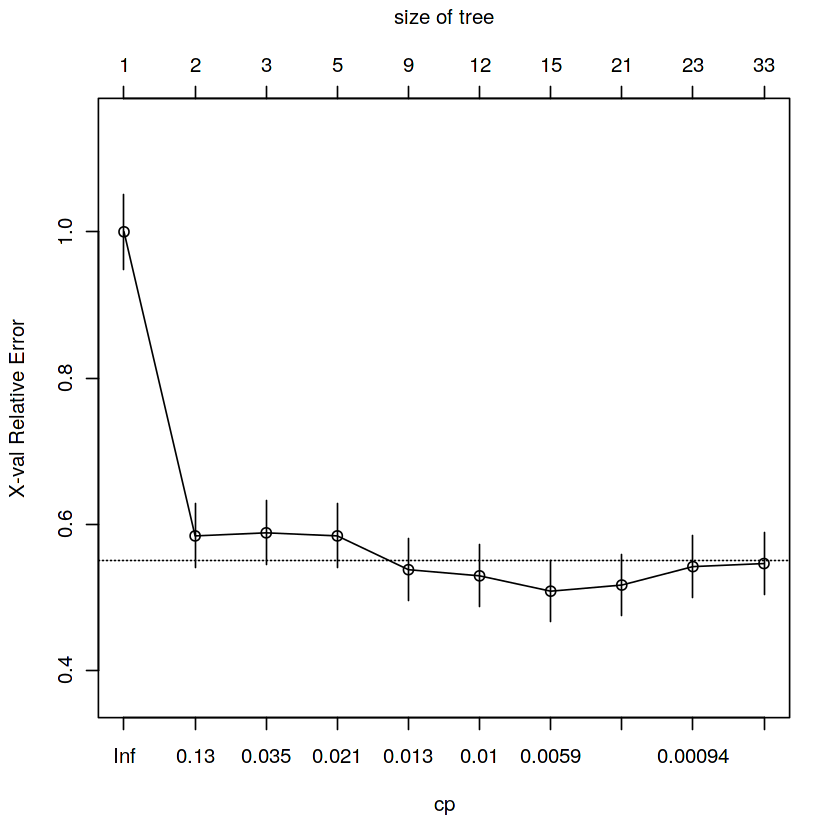

   
      0   1
  0 145  12
  1  31  73

[1] 0.835249

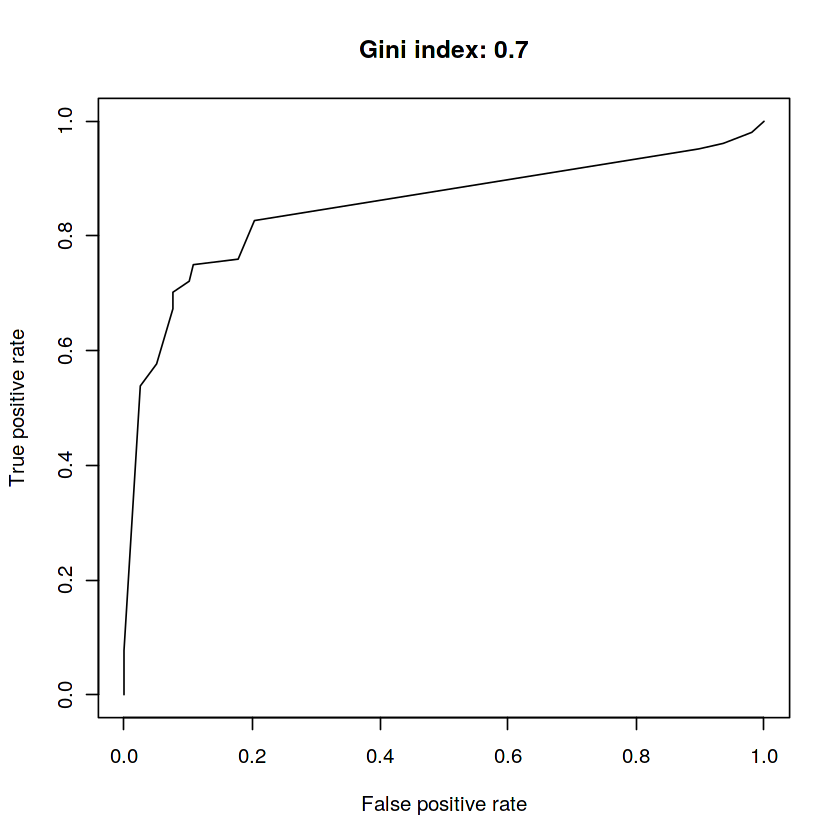

In [35]:
set.seed(1234)
rTree=rpart(form,data=trn,minsplit=10,minbucket=5,method="class",cp=0.00000000001)
cp=data.table(printcp(rTree))
plotcp(rTree)
rTreePruned=prune(rTree,cp=cp[which.min(cp$xerror),]$CP)
g_rTreePruned=rocplot(predict(rTreePruned,val,type="prob")[,2],val$Survived)
(confMat=table(val$Survived,predict(rTreePruned,val,type='class')))
sum(diag(confMat))/sum(confMat)

   
      0   1
  0 142  15
  1  32  72


[1] 0.8199234

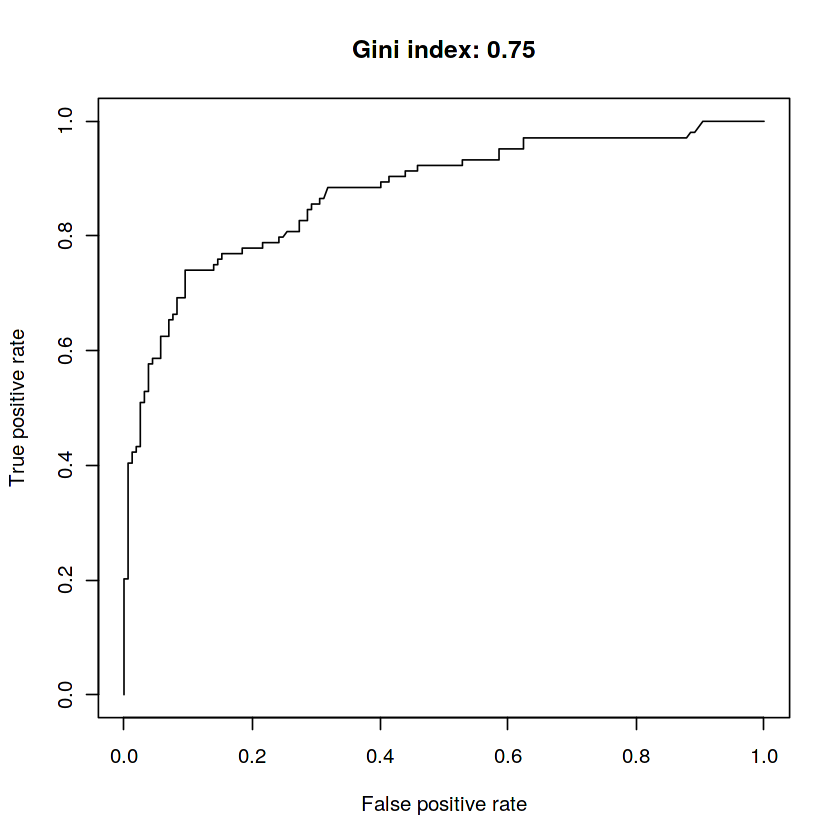

In [37]:
trn$Survived=factor(trn$Survived)
val$Survived=factor(val$Survived)
set.seed(1234)
bagForest=randomForest(form,data=trn,mtry=12,ntree=10000,nodesize=10,importance=TRUE,keep.inbag=TRUE,keep.forest=TRUE)
g_bagForest=rocplot(predict(bagForest,val,type='prob')[,2],val$Survived)
confMat=table(val$Survived,predict(bagForest,val,type='class'))
print(confMat)
sum(diag(confMat))/sum(confMat)

   
      0   1
  0 142  15
  1  33  71


[1] 0.816092

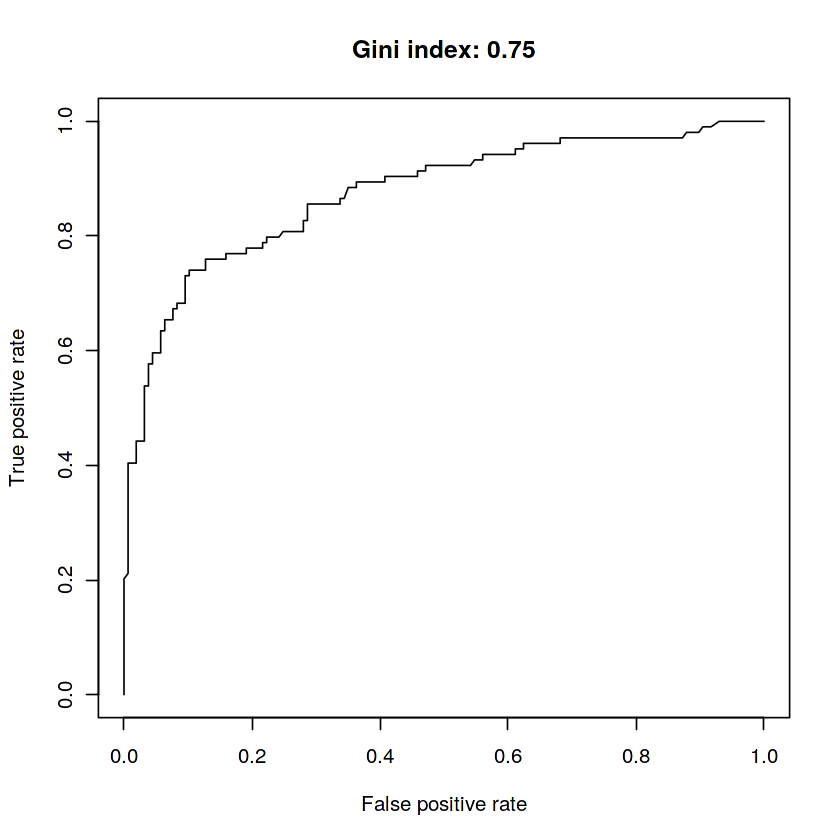

In [38]:
trn$Survived=factor(trn$Survived)
val$Survived=factor(val$Survived)
set.seed(1234)
bagForest=randomForest(form,data=trn,mtry=15,ntree=10000,nodesize=10,importance=TRUE,keep.inbag=TRUE,keep.forest=TRUE)
g_bagForest=rocplot(predict(bagForest,val,type='prob')[,2],val$Survived)
confMat=table(val$Survived,predict(bagForest,val,type='class'))
print(confMat)
sum(diag(confMat))/sum(confMat)

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.



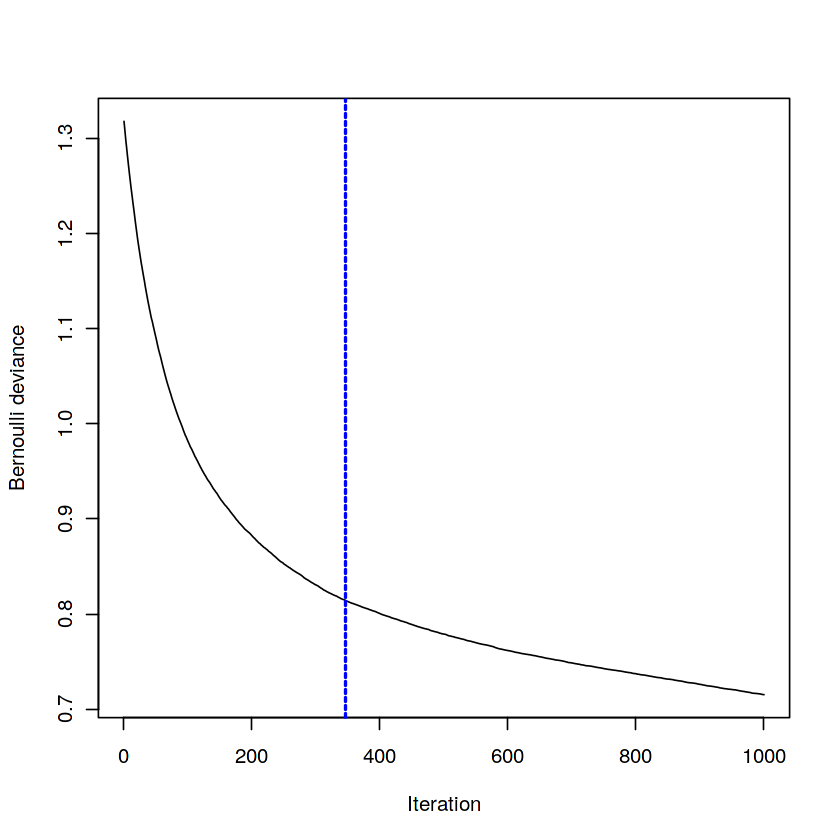

[1] 0.8275862

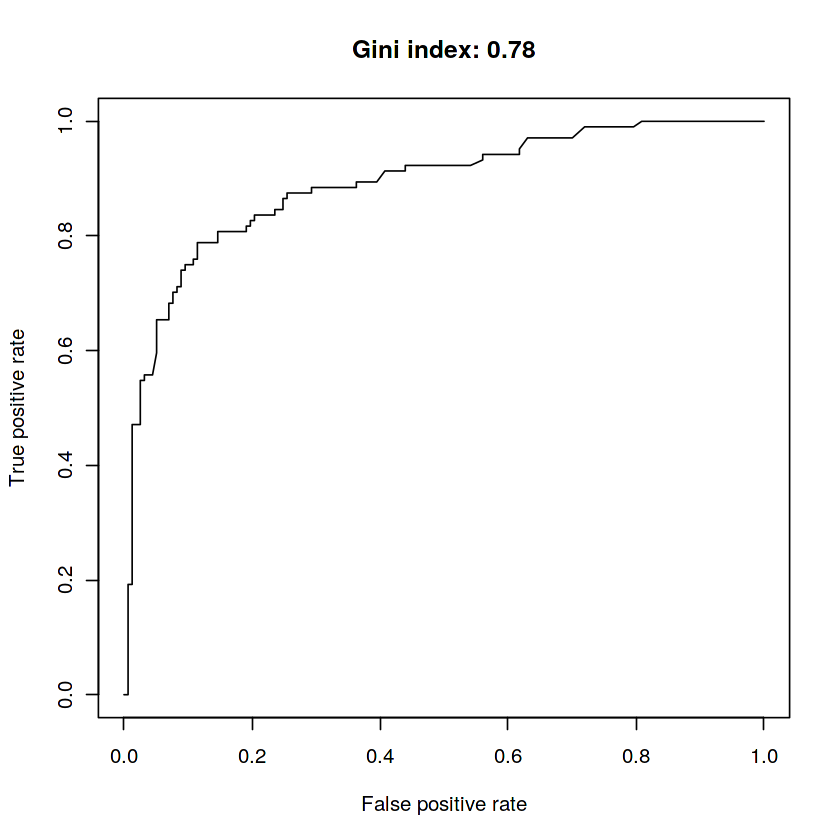

In [39]:
trn[,Survived:=as.integer(Survived)-1]
val[,Survived:=as.integer(Survived)-1]
set.seed(1234)
boostForest=gbm(form,data=trn,distribution='bernoulli',n.trees=1000,interaction.depth=2,shrinkage=0.01,n.minobsinnode=10)
iterOpt=gbm.perf(boostForest)
testPredict=predict.gbm(boostForest,newdata=val,n.trees=iterOpt,type='response')
g_boostForest=rocplot(testPredict,val$Survived)
confMat=table(val$Survived,ifelse(testPredict>0.5,1,0))
sum(diag(confMat))/sum(confMat)

   
      0   1
  0 146  11
  1  31  73


[1] 0.8390805

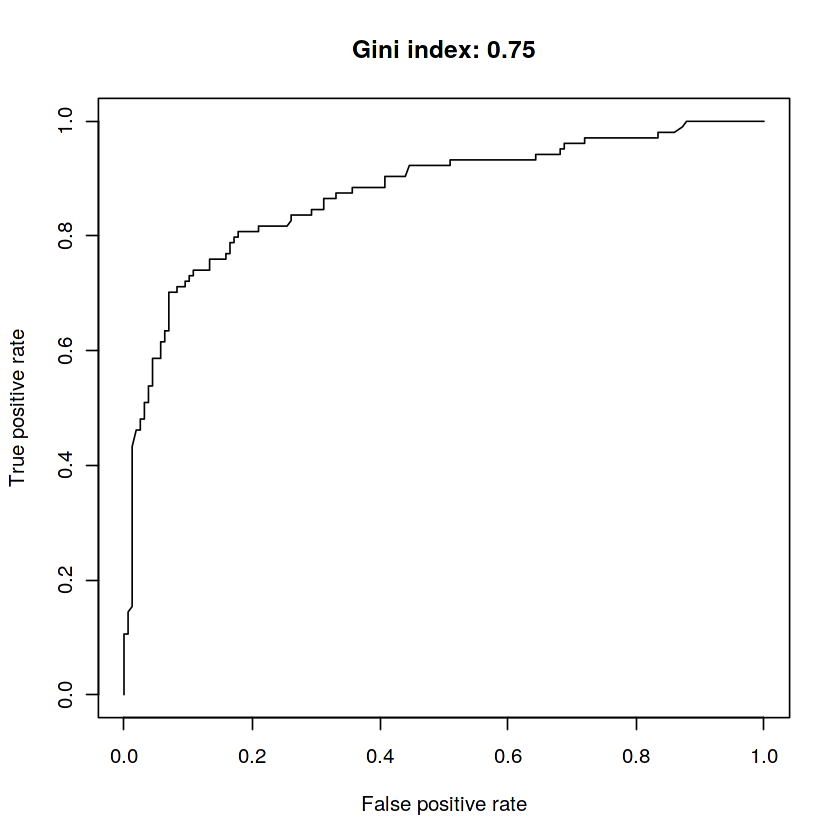

In [40]:
set.seed(1234)
adaDisc=ada(form,data=trn,iter=500,test.x=val[,.SD,.SDcols=setdiff(names(val),'Survived')],test.y=val$Survived,loss='e',type='discrete',control=default)
g_adaDisc=rocplot(predict(adaDisc,val,type='prob',n.iter=which.min(adaDisc$model$errs[,3]))[,2],val$Survived)
confMat=table(val$Survived,predict(adaDisc,val,n.iter=which.min(adaDisc$model$errs[,3])))
print(confMat)
sum(diag(confMat))/sum(confMat)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
 0.01

- best performance: 0.7972999 



     predict
truth  -1   1
   -1 136  21
   1   31  73

[1] 0.8007663

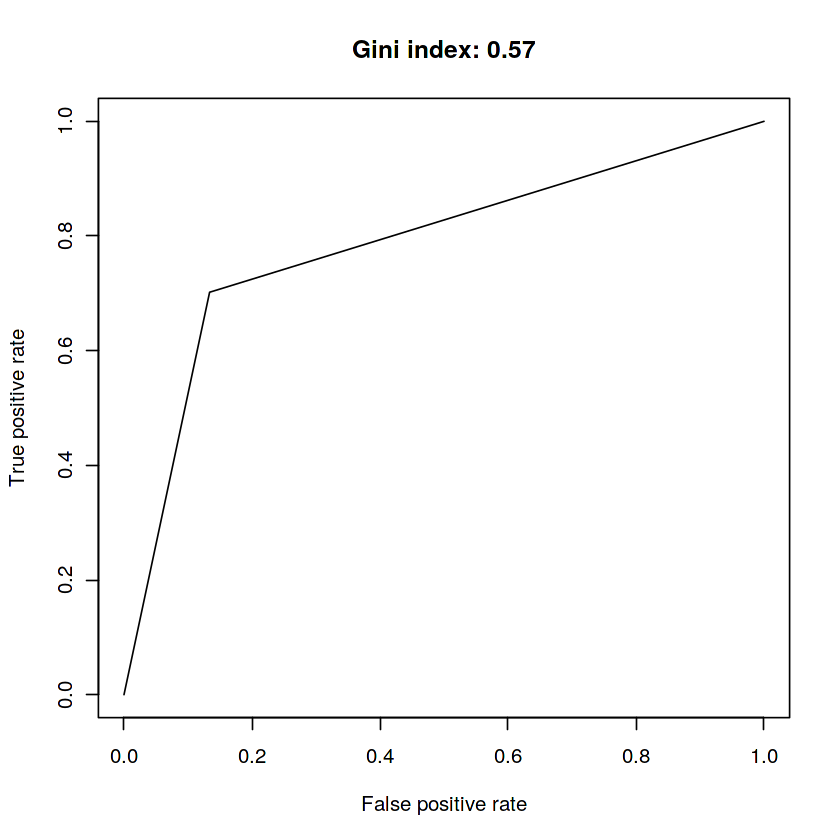

In [41]:
trn[Survived==0,Survived:=-1]
val[Survived==0,Survived:=-1]
set.seed(1234)
modelSVM=svm(form,data=trn,kernel='linear',cost=10,scale=FALSE)
svmTune=tune(svm,train.x=trn[,-c(1,8)],train.y=trn[,1],kernel='linear',ranges=list(cost=10^(-2:2)))
print(svmTune)
svmTuned=svm(form,data=trn,kernel='linear',cost=0.01,scale=FALSE)
svmPred=predict(svmTuned,val[,-c(1,8)],type='prob')
(confMat=table(truth=val$Survived,predict=ifelse(svmPred>0,1,-1)))
sum(diag(confMat))/sum(confMat)
rocplot(ifelse(svmPred>0,1,-1),val$Survived)

Let's look at the results.

In [42]:
result_hot=data.table(Method=c('PrunedTree','RandomForest','Bagging','BoostForest','ADAdisc','SVMlinear'),Accuracy=c(0.835,0.820,0.816,0.828,0.839,0.801),GiniIndex=c(0.70,0.75,0.75,0.78,0.74,0.57))
result_hot[order(Accuracy,decreasing=TRUE)]

Method,Accuracy,GiniIndex
<chr>,<dbl>,<dbl>
ADAdisc,0.839,0.74
PrunedTree,0.835,0.70
BoostForest,0.828,0.78
RandomForest,0.820,0.75
Bagging,0.816,0.75
SVMlinear,0.801,0.57


We conclude that despite the fact that same methods have different results with different approach, those differences are not significant enough to matter. 